<a href="https://colab.research.google.com/github/robmaz22/Kaggle-competitions/blob/main/Medical_Insurance_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting cost of insurance using ML models

## Dataset: [Medical Insurance dataset](https://www.kaggle.com/rajgupta2019/medical-insurance-dataset)

Dataset info: The dataset containing details of users in a medical Insurance company.

##Download Kaggle dataset 

In [1]:
!pip install -q kaggle
from google.colab import files

files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rajgupta2019/medical-insurance-dataset
!unzip medical-insurance-dataset.zip

Saving kaggle.json to kaggle.json
  0% 0.00/92.1k [00:00<?, ?B/s]
100% 92.1k/92.1k [00:00<00:00, 22.0MB/s]
Archive:  medical-insurance-dataset.zip
  inflating: Test_Data.csv           
  inflating: Train_Data.csv          


##Import necessary libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
from numpy.random import uniform

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

##Read train dataset from csv

In [4]:
raw_data = pd.read_csv('Train_Data.csv')

In [5]:
raw_data.head()

,age,sex,bmi,smoker,region,children,charges
0,21.000000,male,25.745000,no,northeast,2,3279.868550
1,36.976978,female,25.744165,yes,southeast,3,21454.494239
2,18.000000,male,30.030000,no,southeast,1,1720.353700
3,37.000000,male,30.676891,no,northeast,3,6801.437542
4,58.000000,male,32.010000,no,southeast,1,11946.625900


##Dataset analysis

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3630 entries, 0 to 3629
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       3630 non-null   float64
 1   sex       3630 non-null   object 
 2   bmi       3630 non-null   float64
 3   smoker    3630 non-null   object 
 4   region    3630 non-null   object 
 5   children  3630 non-null   int64  
 6   charges   3630 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 198.6+ KB


In [7]:
raw_data.isna().sum()

age         0
sex         0
bmi         0
smoker      0
region      0
children    0
charges     0
dtype: int64

In [8]:
raw_data.describe()

,age,bmi,children,charges
count,3630.000000,3630.000000,3630.000000,3630.000000
mean,38.887036,30.629652,2.503581,12784.808644
std,12.151029,5.441307,1.712568,10746.166743
min,18.000000,15.960000,0.000000,1121.873900
25%,29.000000,26.694526,1.000000,5654.818262
50%,39.170922,30.200000,3.000000,9443.807222
75%,48.343281,34.100000,4.000000,14680.407505
max,64.000000,53.130000,5.000000,63770.428010


##Data preprocesing

In [9]:
data = raw_data.copy()

In [10]:
enc = OrdinalEncoder()

In [11]:
def preprocess(df, train=False):
  if train:
    df['region'] = enc.fit_transform(df[['region']])
  else:
    df['region'] = enc.transform(df[['region']])

  df['sex'] = df['sex'].map({'male' : 0, 'female': 1})
  df['smoker'] = df['smoker'].map({'no' : 0, 'yes' : 1})

  return df

In [12]:
X = data
y = X.pop('charges')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
X_train = preprocess(X_train, True)
X_train

,age,sex,bmi,smoker,region,children
2327,18.000000,1,31.130000,0,2.0,0
344,42.000000,0,35.954114,0,0.0,2
1837,38.000000,1,37.730000,0,2.0,0
1691,36.000000,0,27.550000,0,0.0,3
941,50.699963,1,38.675160,0,1.0,4
...,...,...,...,...,...,...
3168,63.000000,0,28.310000,0,1.0,0
3148,54.359271,1,37.609561,0,1.0,3
3443,59.310381,0,31.892829,1,0.0,3
3219,43.473738,0,24.850000,1,1.0,2


Text(0.5, 1.0, 'Correlation for train set')

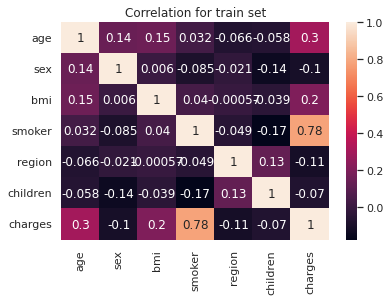

In [15]:
correlation = pd.concat([X_train, y_train], axis=1)

sns.heatmap(correlation.corr(), annot=True)
plt.title('Correlation for train set')

In [16]:
X_test = preprocess(X_test)

##Select best model and params

In [17]:
rgr1 = LinearRegression(n_jobs=-1)
rgr2 = LGBMRegressor(n_jobs=-1)
rgr3 = XGBRegressor(n_jobs=-1)
rgr4 = SGDRegressor(max_iter=10000, random_state=1)
rgr5 = ElasticNet()
rgr6 = SVR()

In [18]:
pipe = Pipeline([('scaler', StandardScaler()), ('regressor', rgr1)])

In [19]:
params1 = {'classifier' : [rgr1]}

params2 = {'regressor__boosting_type': ['gbdt',
                             'dart',
                             'goss',
                             'rf'],
           'regressor__num_leaves' : range(1, 100),
           'regressor__max_depth' : range(2, 100),
           'regressor__learning_rate' : uniform(0, 1, 100),
           'regressor__n_estimators' : range(200),
           'regressor' : [rgr2]
           }

params3 = {'regressor__n_estimators' : range(200),
           'regressor__max_depth' : range(2, 100),
           'regressor__learning_rate' : uniform(0, 1, 100),
           'regressor__boster' : ['gbtree', 'gblinear', 'dart'],
           'regressor' : [rgr3]
           }

params4 = {'regressor__loss': ['squared_error',
                    'huber',
                    'epsilon_insensitive',
                    'squared_epsilon_insensitive'],
           'regressor__penalty' : ['l2', 'l1', 'elasticnet'],
           'regressor__alpha' : uniform(0, 1, 10000),
           'regressor__tol' : uniform(0, 1, 1000),
           'regressor__epsilon' : uniform(0, 1, 100),
           'regressor__learning_rate' : ['constant',
                                         'optimal',
                                         'invscaling',
                                         'adaptive'],
           'regressor__eta0' : uniform(0, 1, 10000),
           'regressor__power_t' : uniform(0, 1, 10000),
           'regressor' : [rgr4]
           }

params5 = {'regressor__alpha' : uniform(0, 1, 100),
           'regressor__l1_ratio' : [0.1, 0.2, 0.3,
                         0.4, 0.5, 0.6, 
                         0.7, 0.8, 0.9],
           'regressor' : [rgr5]}

params6 = {'regressor__kernel' : ['linear',
                       'poly',
                       'rbf',
                       'sigmoid',
                       'precomputed'],
           'regressor__degree' : range(10),
           'regressor__gamma' : ['scale', 'auto'],
           'regressor__tol' : uniform(0, 1, 1000),
            'regressor__C': [0.1, 1.0, 10.0, 100.0],
           'regressor' : [rgr6]}

In [20]:
params = [params1, params2, params3, params4, params5, params6]

random_grid = RandomizedSearchCV(pipe, params, n_jobs=-1, scoring='r2')
random_grid.fit(X_train, y_train)
print(f'Best estimator: {random_grid.best_estimator_}')

Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 SGDRegressor(alpha=0.24398357837788542,
                              epsilon=0.8002537698906682,
                              eta0=0.4378034065710017, learning_rate='adaptive',
                              max_iter=10000, penalty='l1',
                              power_t=0.39585179823769334, random_state=1,
                              tol=0.19070255004327863))])


In [28]:
train_score = round(random_grid.best_score_, 3)
print(f'Best R2 score for train set: {train_score:.2f}')
train_pred = random_grid.predict(X_train)
print(f'Mean squared error for train set: {mean_squared_error(y_train, train_pred):.2f}')
print()
test_pred = random_grid.predict(X_test)
print(f'R2 score for test set: {r2_score(y_test, test_pred):.2f}')
print(f'Mean squared error for test set: {mean_squared_error(y_test, test_pred):.2f}')

Best R2 score for train set: 0.72
Mean squared error for train set: 32339876.35

R2 score for test set: 0.70
Mean squared error for test set: 33773411.66


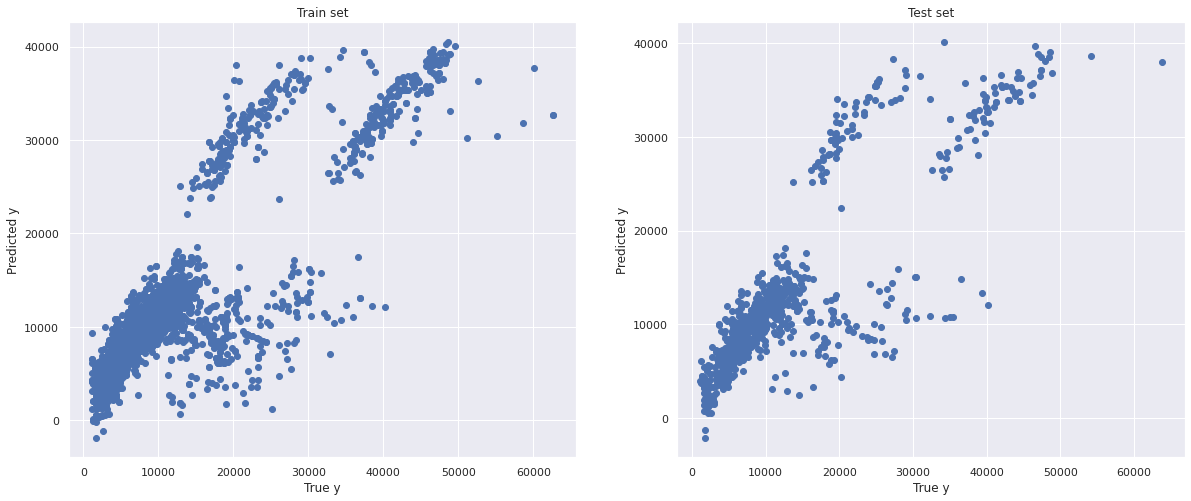

In [22]:
plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
plt.scatter(y_train, train_pred)
plt.xlabel('True y')
plt.ylabel('Predicted y')
plt.title('Train set')

plt.subplot(1, 2, 2)
plt.scatter(y_test, test_pred)
plt.xlabel('True y')
plt.ylabel('Predicted y')
plt.title('Test set')

plt.show()

##Predict values

In [23]:
test_data = pd.read_csv('Test_Data.csv')

In [24]:
test_data.head()

,age,sex,bmi,smoker,region,children
0,40.000000,male,29.900000,no,southwest,2
1,47.000000,male,32.300000,no,southwest,1
2,54.000000,female,28.880000,no,northeast,2
3,37.000000,male,30.568094,no,northeast,3
4,59.130049,male,33.132854,yes,northeast,4


In [25]:
test_data = preprocess(test_data)

In [26]:
predicted_charges = random_grid.predict(test_data)

In [27]:
test_data['predicted_charges'] = predicted_charges
test_data.head()

,age,sex,bmi,smoker,region,children,predicted_charges
0,40.000000,0,29.900000,0,3.0,2,8697.669532
1,47.000000,0,32.300000,0,3.0,1,10467.713874
2,54.000000,1,28.880000,0,0.0,2,12196.047239
3,37.000000,0,30.568094,0,0.0,3,10610.376149
4,59.130049,0,33.132854,1,0.0,4,40216.653339
